In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [2]:
games = pd.read_csv('CSV/games_slim.csv', encoding='latin-1', index_col = False)
games_pred = pd.read_csv('CSV/games_pred.csv', encoding='latin-1', index_col = False, )
games = games.iloc[:,1:]
games_pred = games_pred.iloc[:,1:]
runs = games_pred['Runs']
games['Runs'] = runs
seed = 1

In [3]:
games.head()

,DP_SIDE_pit,FB%_SIDE_pit,GB%_SIDE_pit,LD%_SIDE_pit,AVG_SIDE_pit,OBP_SIDE_pit,TAV_SIDE_pit,R_Pitching_Std,HR_Pitching_Std,BB_Pitching_Std,...,TAV_SIDEbatter_Std,Temp,Humidity,Wind,STADIUM,Wind_Level,FB%_Level,Temp_Level,Humidity_Level,Runs
0,0.019,0.216,0.452,0.262,0.224,0.303,0.254,0.2637,0.0569,0.2251,...,0.2812,69,77,0.0,CHN,2,2,2,2,1
1,0.027,0.187,0.493,0.266,0.233,0.294,0.249,0.3029,0.0805,0.1920,...,0.3030,80,42,0.0,LAN,2,1,3,1,5
2,0.026,0.232,0.452,0.239,0.265,0.318,0.285,0.2554,0.0557,0.2003,...,0.2809,67,68,4.0,PHI,3,2,2,2,3
3,0.021,0.215,0.490,0.252,0.214,0.302,0.257,0.2332,0.0668,0.2369,...,0.2324,68,72,3.0,BAL,3,2,2,2,4
4,0.013,0.239,0.417,0.246,0.217,0.291,0.225,0.2536,0.0891,0.1822,...,0.2488,66,67,12.0,SFN,3,2,2,2,0


In [4]:
games_pred.head()

,Dates,Teams,Runs,Predict
0,10/1/2018,MIL,1,4.0
1,10/1/2018,COL,5,4.0
2,9/30/2018,ATL,3,4.0
3,9/30/2018,HOU,4,4.0
4,9/30/2018,LAN,0,4.0


This analysis is part of a larger project that seeks to determine what factors effect the number of runs scored in a game and to use them to make better predictions.  After exploritory analysis was run, certain elements of the weather showed enough potential effect to warrant further investigation. The effect of temperature, wind and humidity on the number of runs scored in mlb games are examined in this notebook.

### __Humidity__

In [5]:
h33 = 62 # np.percentile(games['Humidity'], 33, axis=0)
h66 = 76 # np.percentile(games['Humidity'], 66, axis=0)

In [6]:
# Create data frame for games with temps between 58 and 81
games2 = games[(games['Humidity'] >= 47) & (games['Humidity'] < 91) & (games['Runs'] < 10)].copy()

h1 = games2['Runs'][(games2['Humidity'] >= 47) & (games2['Humidity'] < 62)]
h2 = games2['Runs'][(games2['Humidity'] >= 62) & (games2['Humidity'] < 76)]
h3 = games2['Runs'][(games2['Humidity'] >= 76) & (games2['Humidity'] < 91)]

games2['Humidity_Level1'] = 0
games2.loc[games2.Humidity < 66, 'Humidity_Level1'] = 1
games2.loc[(games2.Humidity >= 66) & (games2.Temp < 74), 'Humidity_Level1'] = 2
games2.loc[games2.Humidity >= 74, 'Humidity_Level1'] = 3

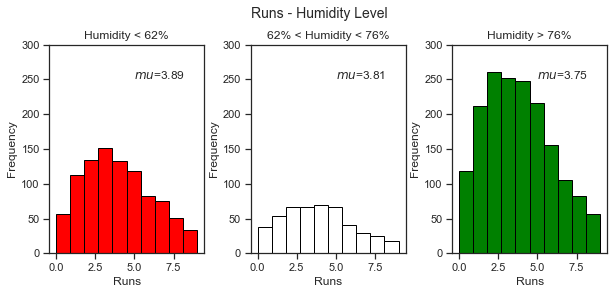

In [7]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Runs - Humidity Level", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_title("Humidity < {}%".format(h33))
ax1.set_xlabel("Runs")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 300])
ax1.text(5, 250, r'$mu$='+str(round(games2['Runs'][games2['Humidity_Level1']==1].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(games2['Runs'][games2['Humidity_Level1']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_title("{0}% < Humidity < {1}%".format(h33, h66))
ax2.set_xlabel("Runs")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 300])
ax2.text(5, 250, r'$mu$='+str(round(games2['Runs'][games2['Humidity_Level1']==2].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(games2['Runs'][games2['Humidity_Level1']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax3 = fig.add_subplot(1,3, 3)
ax3.set_title("Humidity > {}%".format(h66))
ax3.set_xlabel("Runs")
ax3.set_ylabel("Frequency")
ax3.set_ylim([0, 300])
ax3.text(5, 250, r'$mu$='+str(round(games2['Runs'][games2['Humidity_Level1']==3].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax3.hist(games2['Runs'][games2['Humidity_Level1']==3], color='green', bins=10,
                                      edgecolor='black', linewidth=1)

There is less between-group difference than with the temperature groups.  A quick exploration is likely all that is warranted.

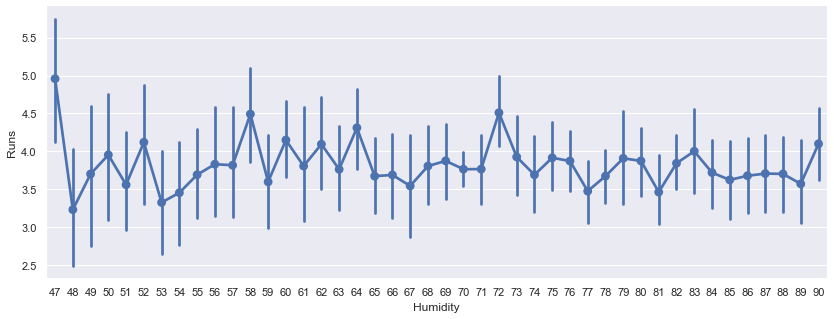

In [8]:
sns.set()
f, ax = plt.subplots(figsize=(14, 5))
sns.pointplot('Humidity', 'Runs', data=games2)
sns.despine(bottom=True)
plt.show()

In [9]:
X = games2['Humidity'] ## X usually means our input variables (or independent variables)
y = games2['Runs'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

C:\Users\mrcrb\Anaconda3\envs\jupyter_notebooks\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Runs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9227
Date:                Tue, 04 Feb 2020   Prob (F-statistic):              0.337
Time:                        19:26:47   Log-Likelihood:                -8547.8
No. Observations:                3738   AIC:                         1.710e+04
Df Residuals:                    3736   BIC:                         1.711e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0664      0.266     15.298      0.000       3.545       4.588
Humidity      -0.0035      0.004     -0.961      0.337      -0.011       0.004
==============================================================================
Omnibus:                      262.077   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.580
Skew:                           0.333   Prob(JB):                     2.44e-32
Kurtosis:                       2.299   Cond. No.                         497.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
from sklearn.utils import resample
def bootstrap(sample, resample_size):
    sample_boot = []
    for i in range(resample_size):
        np.random.seed(i)
        sample_boot.append((resample(sample)))
    return sample_boot

h1_bootstrap = bootstrap(h1, 10000)
h1_bootstrap = np.mean(h1_bootstrap, axis=1)
h2_bootstrap = bootstrap(h2, 10000)
h2_bootstrap = np.mean(h2_bootstrap, axis=1)
h3_bootstrap = bootstrap(h3, 10000)
h3_bootstrap = np.mean(h3_bootstrap, axis=1)
#h_all_bootstrap = bootstrap(h_all, 10000)
#h_all_bootstrap = np.mean(h_all_bootstrap, axis=1)

differences1 = (h1_bootstrap - h3_bootstrap)
differences2 = (h2_bootstrap - h3_bootstrap)
differences3 = (h1_bootstrap - h2_bootstrap)

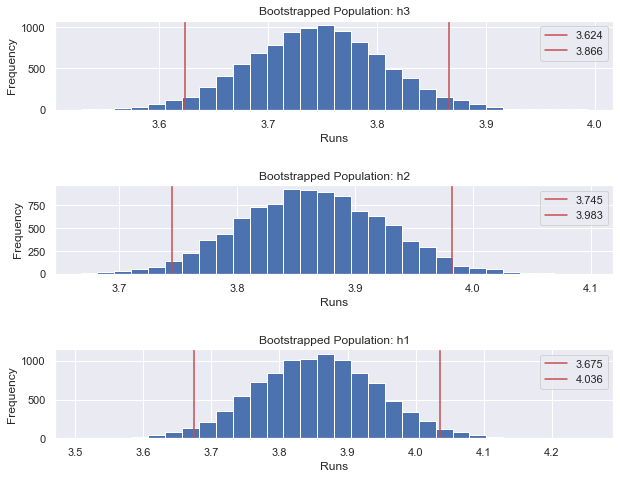

95% Confidence Intervals for Temperature Categories
h3:     Lower bound: 3.624     Upper bound: 3.866
h2:     Lower bound: 3.745     Upper bound: 3.983
h1:     Lower bound: 3.675     Upper bound: 4.036


In [11]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.85, wspace=0.3)

lower_bound_h3 = np.percentile(h3_bootstrap, 2.5)
upper_bound_h3 = np.percentile(h3_bootstrap, 97.5)

ax1 = fig.add_subplot(3,1, 1)
ax1.set_xlabel('Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound_h3, color='r', label=round(lower_bound_h3,3))
ax1.axvline(upper_bound_h3, color='r', label=round(upper_bound_h3,3))
ax1.set_title('Bootstrapped Population: h3')
ax1_hist = ax1.hist(h3_bootstrap, bins=30)
ax1.legend()

lower_bound_h2 = np.percentile(h2_bootstrap, 2.5)
upper_bound_h2 = np.percentile(h2_bootstrap, 97.5)

ax2 = fig.add_subplot(3,1, 2)
ax2.set_xlabel('Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound_h2, color='r', label=round(lower_bound_h2,3))
ax2.axvline(upper_bound_h2, color='r', label=round(upper_bound_h2,3))
ax2.set_title('Bootstrapped Population: h2')
ax2_hist = ax2.hist(h2_bootstrap, bins=30)
ax2.legend()

lower_bound_h1 = np.percentile(h1_bootstrap, 2.5)
upper_bound_h1 = np.percentile(h1_bootstrap, 97.5)

ax3 = fig.add_subplot(3,1, 3)
ax3.set_xlabel('Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound_h1, color='r', label=round(lower_bound_h1,3))
ax3.axvline(upper_bound_h1, color='r', label=round(upper_bound_h1,3))
ax3.set_title('Bootstrapped Population: h1')
ax3_hist = ax3.hist(h1_bootstrap, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Temperature Categories')
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("h3", lower_bound_h3, upper_bound_h3))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("h2", lower_bound_h2, upper_bound_h2))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("h1", lower_bound_h1, upper_bound_h1))

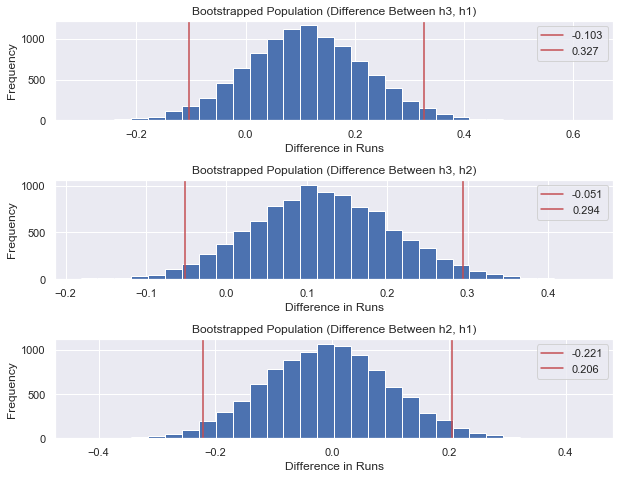

95% Confidence Intervals for Mean Differce between h1 & h3:
Lower bound: -0.103
Upper bound: 0.327
Number of samples where (mean) h3 > h1: 1568

95% Confidence Intervals for Mean Differce between h2 & h3:
Lower bound: -0.051
Upper bound: 0.294
Number of samples where (mean) h3 > h2: 889

95% Confidence Intervals for Mean Differce between h1 & h2:
Lower bound: -0.221
Upper bound: 0.206
Number of samples where (mean) h2 > h1: 5319


In [12]:
lower_bound1 = np.percentile(differences1, 2.5)
upper_bound1 = np.percentile(differences1, 97.5)
lower_bound2 = np.percentile(differences2, 2.5)
upper_bound2 = np.percentile(differences2, 97.5)
lower_bound3 = np.percentile(differences3, 2.5)
upper_bound3 = np.percentile(differences3, 97.5)

fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.6)

ax1 = fig.add_subplot(3, 1, 1)
ax1.set_xlabel('Difference in Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound1, color='r', label=round(lower_bound1,3))
ax1.axvline(upper_bound1, color='r', label=round(upper_bound1,3))
ax1.set_title('Bootstrapped Population (Difference Between h3, h1)')
ax1_hist = ax1.hist(differences1, bins=30)
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_xlabel('Difference in Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound2, color='r', label=round(lower_bound2,3))
ax2.axvline(upper_bound2, color='r', label=round(upper_bound2,3))
ax2.set_title('Bootstrapped Population (Difference Between h3, h2)')
ax2_hist = ax2.hist(differences2, bins=30)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_xlabel('Difference in Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound3, color='r', label=round(lower_bound3,3))
ax3.axvline(upper_bound3, color='r', label=round(upper_bound3,3))
ax3.set_title('Bootstrapped Population (Difference Between h2, h1)')
ax3_hist = ax3.hist(differences3, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('h1', 'h3'))
print('Lower bound: {0:5.3f}'.format(lower_bound1))
print('Upper bound: {0:5.3f}'.format(upper_bound1))

p1 = differences1[differences1 <= 0].shape[0]
print("Number of samples where (mean) h3 > h1: {}\n".format(p1))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('h2', 'h3'))
print('Lower bound: {0:5.3f}'.format(lower_bound2))
print('Upper bound: {0:5.3f}'.format(upper_bound2))

p2 = differences2[differences2 <= 0].shape[0]
print("Number of samples where (mean) h3 > h2: {}\n".format(p2))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('h1', 'h2'))
print('Lower bound: {0:5.3f}'.format(lower_bound3))
print('Upper bound: {0:5.3f}'.format(upper_bound3))

p3 = differences3[differences3 <= 0].shape[0]
print("Number of samples where (mean) h2 > h1: {}".format(p3))

In [13]:
combined = np.concatenate((h3, h2, h1), axis=0)

perms_h1 = []
perms_h2 = []
perms_h3 = []

for i in range(10000):
    np.random.seed(i)
    perms_h1.append(resample(combined, n_samples = len(h1)))
    perms_h2.append(resample(combined, n_samples = len(h2)))
    perms_h3.append(resample(combined, n_samples = len(h3)))
    
dif_bootstrap_means1 = (np.mean(perms_h1, axis=1)-np.mean(perms_h3, axis=1))
dif_bootstrap_means2 = (np.mean(perms_h2, axis=1)-np.mean(perms_h3, axis=1))
dif_bootstrap_means3 = (np.mean(perms_h1, axis=1)-np.mean(perms_h2, axis=1))

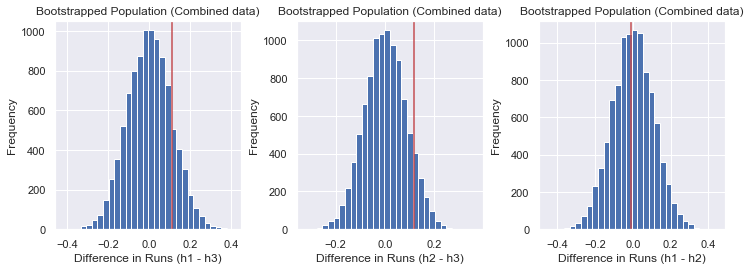

observed difference in means: 0.1100 [h1,h3]
observed difference in means: 0.1191 [h2,h3]
observed difference in means: -0.0091 [h1,h2]
p-value: 0.1541 [h3,h1]
p-value: 0.0867 [h3,h2]
p-value: 0.5344 [h2,h1]


In [14]:
obs_difs1 = np.mean(h1) - np.mean(h3)
obs_difs2 = np.mean(h2) - np.mean(h3)
obs_difs3 = np.mean(h1) - np.mean(h2)

p_value1 = dif_bootstrap_means1[dif_bootstrap_means1 >= obs_difs1].shape[0]/10000
p_value2 = dif_bootstrap_means2[dif_bootstrap_means2 >= obs_difs2].shape[0]/10000
p_value3 = dif_bootstrap_means3[dif_bootstrap_means3 >= obs_difs3].shape[0]/10000

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_xlabel('Difference in Runs (h1 - h3)')
ax1.set_ylabel('Frequency')
ax1.set_title('Bootstrapped Population (Combined data)')
ax1.axvline(obs_difs1, color='r')
d1 = ax1.hist(dif_bootstrap_means1, bins=30)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_xlabel('Difference in Runs (h2 - h3)')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrapped Population (Combined data)')
ax2.axvline(obs_difs2, color='r')
d2 = ax2.hist(dif_bootstrap_means2, bins=30)

ax3 = fig.add_subplot(1,3, 3)
ax3.set_xlabel('Difference in Runs (h1 - h2)')
ax3.set_ylabel('Frequency')
ax3.set_title('Bootstrapped Population (Combined data)')
ax3.axvline(obs_difs3, color='r')
d3 = ax3.hist(dif_bootstrap_means3, bins=30)
plt.show()

print('observed difference in means: {0:5.4f} [h1,h3]'.format(obs_difs1))
print('observed difference in means: {0:5.4f} [h2,h3]'.format(obs_difs2))
print('observed difference in means: {0:5.4f} [h1,h2]'.format(obs_difs3))

print('p-value: {} [h3,h1]'.format(p_value1))
print('p-value: {} [h3,h2]'.format(p_value2))
print('p-value: {} [h2,h1]'.format(p_value3))

In [15]:
anova = stats.f_oneway(h1, h2, h3)
print("anova p-value: {0:5.4f}".format(anova[1]))
print("anova z-value: {0:5.2f}\n".format(anova[0]))

anova p-value: 0.3397
anova z-value:  1.08



A p-value of 0.34 is much larger than the standard 0.05 commonly used as a threshold.  The null hypothesis is accepted.